# Hit Tier HPGe simulation processing
This tutorial describes how to process the HPGe detector simulations from **remage** with **reboost**. It buils on the offical **remage** tutorial [[link]](https://remage.readthedocs.io/en/stable/tutorial.html)

> #### *Note*
>
> To run this tutorial it is recommended to create the following directory structure to organise the outputs and config inputs.
> 
> 


```text
├── cfg
│   └── metadata
├── output
│   ├── stp
│   └── hit
└── reboost_hpge_tutorial.ipynb

> 

## Part 1) Running the remage simulation
Before we can run any post-processing we need to run the Geant4 simulation. For this we follow the remage tutorial to generate the GDML geometry. We save this into the GDML file *cfg/geom.gdml* for use by remage. We also need to save the metadata dictonaries into json files (in the *cfg/metadata* folder as *BEGe.json* and *Coax.json*

We use a slightly modified Geant4 macro to demonstrate some features of reboost (this should be saved as *cfg/th228.mac* to run remage on the command line).

```text
/RMG/Manager/Logging/LogLevel detail

/RMG/Geometry/RegisterDetector Germanium BEGe 001
/RMG/Geometry/RegisterDetector Germanium Coax 002
/RMG/Geometry/RegisterDetector Scintillator LAr 003

/run/initialize

/RMG/Generator/Confine Volume
/RMG/Generator/Confinement/Physical/AddVolume Source

/RMG/Generator/Select GPS
/gps/particle ion
/gps/energy 0 eV
/gps/ion 88 224 # 224-Ra
/process/had/rdm/nucleusLimits 208 224 81 88 #Ra-224 to 208-Pb


/run/beamOn 1000000
```

We then use the remage exectuable (see [[remage-docs]](https://remage.readthedocs.io/en/stable/) for installation instructions) to run the simulation:
> #### *Note*
> Both of *cfg/th228.mac* and *cfg/geometry.gdml* are needed to run remage

```console
$ remage --threads 8 --gdml-files cfg/geom.gdml --output-file output/stp/output.lh5 -- cfg/th228.mac
```

You can lower the number of simulated events to speed up the simulation.



We can use `lh5.show()` to check the output files.

In [6]:
from lgdo import lh5

In [7]:
lh5.show("output/stp/output_t0.lh5")

/
└── stp · struct{det001,det002,det003,vertices} 
    ├── det001 · table{evtid,particle,edep,time,xloc,yloc,zloc} 
    │   ├── edep · array<1>{real} 
    │   ├── evtid · array<1>{real} 
    │   ├── particle · array<1>{real} 
    │   ├── time · array<1>{real} 
    │   ├── xloc · array<1>{real} 
    │   ├── yloc · array<1>{real} 
    │   └── zloc · array<1>{real} 
    ├── det002 · table{evtid,particle,edep,time,xloc,yloc,zloc} 
    │   ├── edep · array<1>{real} 
    │   ├── evtid · array<1>{real} 
    │   ├── particle · array<1>{real} 
    │   ├── time · array<1>{real} 
    │   ├── xloc · array<1>{real} 
    │   ├── yloc · array<1>{real} 
    │   └── zloc · array<1>{real} 
    ├── det003 · table{evtid,particle,edep,time,xloc_pre,yloc_pre,zloc_pre,xloc_post,yloc_post,zloc_post,v_pre,v_post} 
    │   ├── edep · array<1>{real} 
    │   ├── evtid · array<1>{real} 
    │   ├── particle · array<1>{real} 
    │   ├── time · array<1>{real} 
    │   ├── v_post · array<1>{real} 
    │   ├── v_pre

## Part 2) reboost config files
For this tutorial we perform a basic post-processing of the *hit* tier for the two Germanium channels.

### 2.1) Setup the enviroment
First we set up the python enviroment.

In [8]:
from reboost.hpge import hit
import matplotlib.pyplot as plt
import pyg4ometry as pg4
import legendhpges
from legendhpges import draw
import awkward as ak
import logging
import colorlog
import hist
import numpy as np


plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['axes.titlesize'] =12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12


handler = colorlog.StreamHandler()
handler.setFormatter(
    colorlog.ColoredFormatter("%(log_color)s%(name)s [%(levelname)s] %(message)s")
)
logger = logging.getLogger()
logger.handlers.clear()
logger.addHandler(handler)
logger.setLevel(logging.INFO)
logger.info("test")



root [INFO] test


### 2.2) Processing chain and parameters
Next we need to make the processing chain config file.

The processing chain below gives a standard set of steps for a HPGe simulation.
1. first the steps are windowed into hits,
2. the first timestamp and index of each hit is computed (for use in event building),
3. the distance to the detector n+ surface is computed and from this the activeness is calculated (based on the FCCD)
4. the energy in each step is summed to extract the deposited energy (both with and without deadlayer correction),
5. the energy is convolved with the detector response model (gaussian energy resolution).

We also include some step based quantities in the output to show the effect of the processors.



In [9]:
chain = {
        "channels": [
            "det001",
            "det002"
        ],
        "outputs": [
            "t0",                           # first timestamp
            "time",                         # time of each step
            "edep",                         # energy deposited in each step
            "evtid",                    # id of the hit
            "global_evtid",             # global id of the hit
            "distance_to_nplus_surface_mm", # distance to detector nplus surface
            "activeness",                   # activeness for the step
            "rpos_loc",                     # radius of step
            "zpos_loc",                     # z position
            "energy_sum",                   # true summed energy before dead layer or smearing
            "energy_sum_deadlayer",         # energy sum after dead layers
            "energy_sum_smeared"            # energy sum after smearing with resolution
        ],
        "step_group": {          
            "description": "group steps by time and evtid with 10us window",
            "expression": "reboost.hpge.processors.group_by_time(stp,window=10)",
        },
        "locals": {
            "hpge": "reboost.hpge.utils.get_hpge(meta_path=meta,pars=pars,detector=detector)",
            "phy_vol": "reboost.hpge.utils.get_phy_vol(reg=reg,pars=pars,detector=detector)",
        },
        "operations": {
            "t0": {
                "description": "first time in the hit.",
                "mode": "eval",
                "expression": "ak.fill_none(ak.firsts(hit.time,axis=-1),np.nan)",
            },
            "evtid": {
                "description": "global evtid of the hit.",
                "mode": "eval",
                "expression": "ak.fill_none(ak.firsts(hit._evtid,axis=-1),np.nan)",
            },
            "global_evtid": {
                "description": "global evtid of the hit.",
                "mode": "eval",
                "expression": "ak.fill_none(ak.firsts(hit._global_evtid,axis=-1),np.nan)",
            },
            "distance_to_nplus_surface_mm": {
                "description": "distance to the nplus surface in mm",
                "mode": "function",
                "expression": "reboost.hpge.processors.distance_to_surface(hit.xloc, hit.yloc, hit.zloc, hpge, phy_vol.position.eval(), surface_type='nplus',unit='m')",
            },
            "activeness": {
                "description": "activness based on FCCD (no TL)",
                "mode": "eval",
                "expression": "ak.where(hit.distance_to_nplus_surface_mm<pars.fccd_in_mm,0,1)",
            },
             "rpos_loc": {
                "description": "Local radius ",
                "mode": "eval",
                "expression": "((1000*hit.xloc-phy_vol.position.eval()[0])**2+(1000*hit.yloc-phy_vol.position.eval()[1])**2)**0.5"
            },
             "zpos_loc": {
                "description": "Local z ",
                "mode": "eval",
                "expression": "1000*hit.zloc-phy_vol.position.eval()[2]"
            },
            "energy_sum": {
                "description": "truth summed energy in the hit.",
                "mode": "eval",
                "expression": "ak.sum(hit.edep,axis=-1)",
            },
            "energy_sum_deadlayer": {
                "description": "summed energy in the hit after deadlayr",
                "mode": "eval",
                "expression": "ak.sum(hit.edep*hit.activeness,axis=-1)",
            },
            "energy_sum_smeared": {
                "description": "summed energy after convolution with energy response.",
                "mode": "function",
                "expression": "reboost.hpge.processors.smear_energies(hit.energy_sum_deadlayer,reso=pars.fwhm_in_keV/2.355)"
            }
    
        }
}

We also create our parameters file.

In [10]:
pars = {
    "det001": {
        "meta_name":"BEGe.json",
        "phy_vol_name":"BEGe",
        "fwhm_in_keV":2.69, 
        "fccd_in_mm":1.420, # dead layer in mm     
    },
    "det002": {
        "meta_name":"Coax.json",
        "phy_vol_name":"Coax",
        "fwhm_in_keV":4.420, 
        "fccd_in_mm":2.69,   
    }
    
}

## Part 3)  Running the processing
Now we can run our post-processing

In [12]:
%%time
hit.build_hit(file_out="output/hit/output.lh5",list_file_in="output/stp/*.lh5", out_field="hit",in_field="stp",
              proc_config=chain,pars=pars,gdml="cfg/geom.gdml",metadata_path="cfg/metadata/",merge_input_files=True)


reboost.hpge.utils [INFO] files contain [1252152, 1248990, 1244422, 1248990, 1258476, 1252152, 1252152, 1242666] events
reboost.hpge.hit [INFO] ...running hit tier for output/stp/output_t0.lh5 and det001
reboost.hpge.hit [INFO] ...running hit tier for output/stp/output_t0.lh5 and det002
reboost.hpge.hit [INFO] ...running hit tier for output/stp/output_t1.lh5 and det001
reboost.hpge.hit [INFO] ...running hit tier for output/stp/output_t1.lh5 and det002
reboost.hpge.hit [INFO] ...running hit tier for output/stp/output_t2.lh5 and det001
reboost.hpge.hit [INFO] ...running hit tier for output/stp/output_t2.lh5 and det002
reboost.hpge.hit [INFO] ...running hit tier for output/stp/output_t3.lh5 and det001
reboost.hpge.hit [INFO] ...running hit tier for output/stp/output_t3.lh5 and det002
reboost.hpge.hit [INFO] ...running hit tier for output/stp/output_t4.lh5 and det001
reboost.hpge.hit [INFO] ...running hit tier for output/stp/output_t4.lh5 and det002
reboost.hpge.hit [INFO] ...running hit t

CPU times: user 2min 38s, sys: 4.73 s, total: 2min 42s
Wall time: 2min 45s


The debugging info printed by *reboost* shows the program iterating over the files and appending to the output file.
Now we can print our output file structure showing the new *hit* oriented data format.



In [13]:
lh5.show("output/hit/output.lh5")

/
├── det001 · HDF5 group 
│   └── hit · table{edep,time,t0,evtid,global_evtid,distance_to_nplus_surface_mm,activeness,rpos_loc,zpos_loc,energy_sum,energy_sum_deadlayer,energy_sum_smeared} 
│       ├── activeness · array<1>{array<1>{real}} 
│       │   ├── cumulative_length · array<1>{real} 
│       │   └── flattened_data · array<1>{real} 
│       ├── distance_to_nplus_surface_mm · array<1>{array<1>{real}} 
│       │   ├── cumulative_length · array<1>{real} 
│       │   └── flattened_data · array<1>{real} 
│       ├── edep · array<1>{array<1>{real}} 
│       │   ├── cumulative_length · array<1>{real} 
│       │   └── flattened_data · array<1>{real} 
│       ├── energy_sum · array<1>{real} 
│       ├── energy_sum_deadlayer · array<1>{real} 
│       ├── energy_sum_smeared · array<1>{real} 
│       ├── evtid · array<1>{real} 
│       ├── global_evtid · array<1>{real} 
│       ├── rpos_loc · array<1>{array<1>{real}} 
│       │   ├── cumulative_length · array<1>{real} 
│       │   └── flatt

The new format is a factor of x17 times smaller than the input file due to the removal of many *step* based fields which use alot of memory and due to the removal of the *vertices* table and the LAr hits. So we can easily read the whole file into memory.
We use *awkward* to analyse the output files.

In [15]:
data_det001 = lh5.read_as("det001/hit","output/hit/output.lh5","ak")
data_det002 = lh5.read_as("det002/hit","output/hit/output.lh5","ak")

In [16]:
data_det001

<Array [{edep: [...], time: [...], ...}, ...] type='835793 * {edep: var * f...'>

## Part 4) Steps in a standard processing chain

The next part of the tutorial gives more details on each step of the processing chain.

### 4.1) Windowing
We can compare the decay index ("evtid" in the "stp" file) to the index of the "hit", the row of the hit table.
We see that only some decays correspond to "hits" in the detector, as we expect. We also see that a single decay does not often produce multiple hits. This is also expected since the probability of detection is fairly low.

(0.0, 100.0)

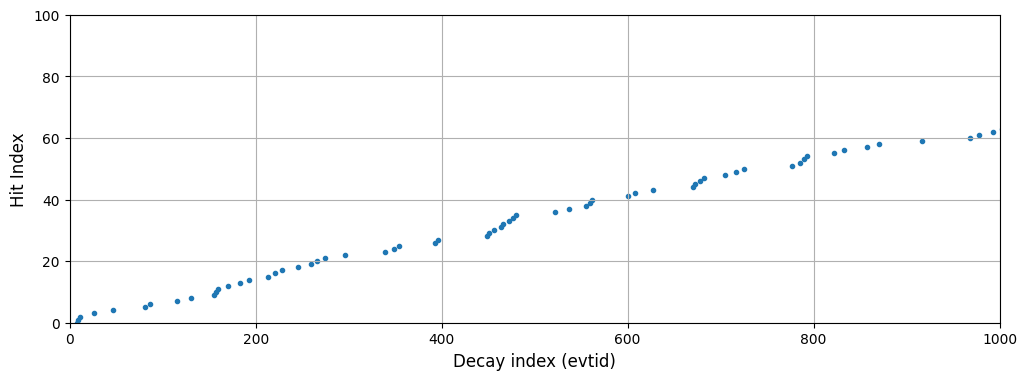

In [18]:
plt.scatter(np.sort(data_det001.global_evtid),np.arange(len(data_det001)),marker=".",alpha=1)
plt.xlabel("Decay index (evtid)")
plt.ylabel("Hit Index")
plt.grid()
plt.xlim(0,1000)
plt.ylim(0,100)

However, we can use some array manipulation to extract decay index with multiple hits, by plotting the times we see the effect of the windowing.

In [19]:
def plot_times(times:ak.Array,xrange=None,sub_zero=False,**kwargs):
    fig,ax = plt.subplots()
    for idx,_time in enumerate(times):
        if (sub_zero):
            _time=_time-ak.min(_time)
        h=hist.new.Reg(100,(ak.min(times)/1e9),(ak.max(times)/1e9)+1, name="Time since event start [s]").Double()
        h.fill(_time/1e9)
        h.plot(**kwargs,label=f"Hit {idx}")
        ax.legend()
        ax.set_yscale("log")
        if xrange is not None:
            ax.set_xlim(*xrange)


In [21]:
unique,counts = np.unique(data_det001.global_evtid,return_counts=True)

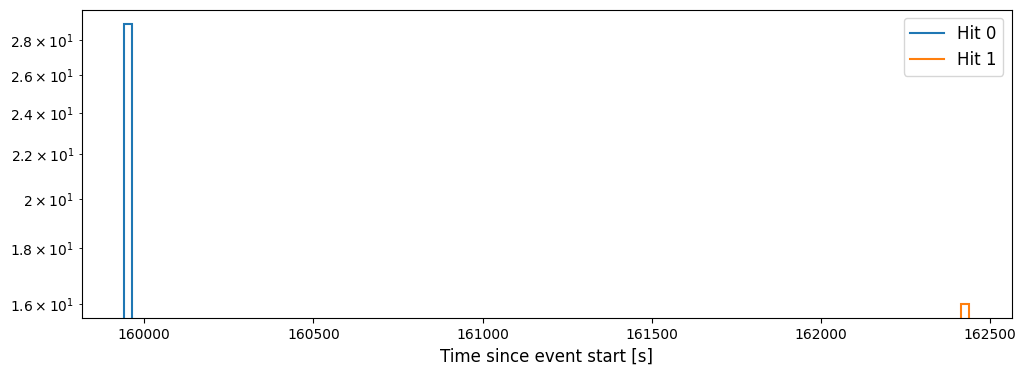

In [23]:
plot_times(data_det001[data_det001.global_evtid==unique[counts>1][1]].time,histtype="step",yerr=False)


### 4.2) Distance to surface and dead layer
One of the important step in the post-processing of HPGe detector simulations is the detector activeness mapping. Energy deposited close to the surface of the Germanium detector will result in incomplete charge collection and a degraded signal.
To account for this we added a processor to compute the distance to the detector surface (based on `legendhpges.base.HPGe.distance_to_surface()`)

For the steps in the detector we extracted in the processing chain the local r and z coordinates and we can plot maps of the distance to the detector surface and the activeness for each step. We select only events within 5 mm of the surface for the first plots. We can see that the processor works as expected.

In [24]:
def plot_map(field,scale="BuPu",clab="Distance [mm]"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    n=100000
    for idx, (data,config) in enumerate(zip([data_det001,data_det002],["cfg/metadata/BEGe.json","cfg/metadata/Coax.json"])):

        reg=pg4.geant4.Registry()
        hpge = legendhpges.make_hpge(config,registry=reg)

        legendhpges.draw.plot_profile(hpge, split_by_type=True,axes=axs[idx])
        r = np.random.choice([-1,1],p=[0.5,0.5],size=len(ak.flatten(data.rpos_loc)))*ak.flatten(data.rpos_loc)
        z = ak.flatten(data.zpos_loc)
        c=ak.flatten(data[field])
        cut = c<5

        s=axs[idx].scatter(r[cut][0:n],z[cut][0:n], c= c[cut][0:n],marker=".", label="gen. points",cmap=scale)
        #axs[idx].axis("equal")

        if idx == 0:
            axs[idx].set_ylabel("Height [mm]")
        c=plt.colorbar(s)
        c.set_label(clab)

        axs[idx].set_xlabel("Radius [mm]")


root [INFO] genericpolycone.antlr>
root [INFO] genericpolyhedra.antlr>
root [INFO] visualisation.Mesh.getBoundingBox> [-36.98, -36.98, 0.0] [36.98, 36.98, 29.46]
root [INFO] box.pycsgmesh> getBoundingBoxMesh
root [INFO] genericpolycone.antlr>
root [INFO] genericpolyhedra.antlr>
root [INFO] visualisation.Mesh.getBoundingBox> [-38.25, -38.25, 0.0] [38.25, 38.25, 84.0]
root [INFO] box.pycsgmesh> getBoundingBoxMesh


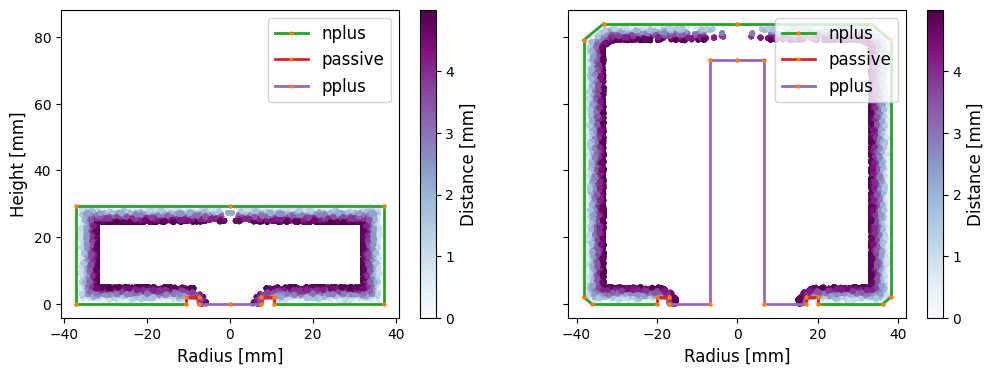

In [25]:
plot_map("distance_to_nplus_surface_mm")

root [INFO] genericpolycone.antlr>
root [INFO] genericpolyhedra.antlr>
root [INFO] visualisation.Mesh.getBoundingBox> [-36.98, -36.98, 0.0] [36.98, 36.98, 29.46]
root [INFO] box.pycsgmesh> getBoundingBoxMesh
root [INFO] genericpolycone.antlr>
root [INFO] genericpolyhedra.antlr>
root [INFO] visualisation.Mesh.getBoundingBox> [-38.25, -38.25, 0.0] [38.25, 38.25, 84.0]
root [INFO] box.pycsgmesh> getBoundingBoxMesh


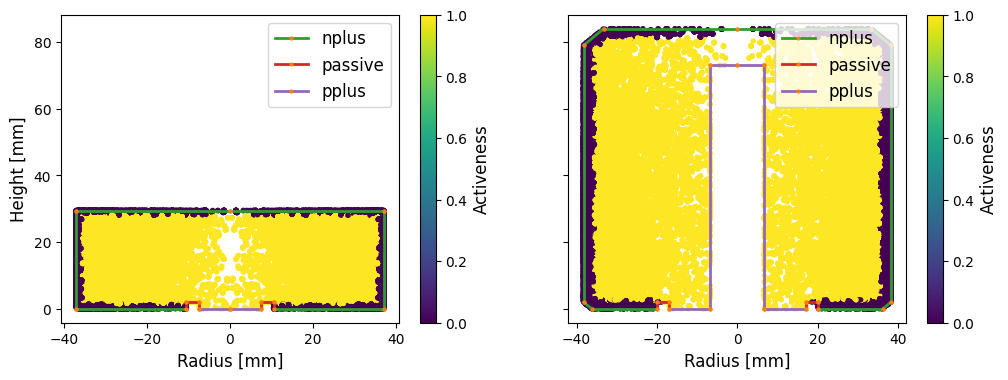

In [26]:
plot_map("activeness",clab="Activeness",scale="viridis")

We can also plot a histogram of the distance to the surface.


In [27]:
def plot_distances(axes,distances,xrange=None,label=" ",**kwargs):
    
    h=hist.new.Reg(100,*xrange, name="Distance to n+ surface [mm]").Double()
    h.fill(distances)
    h.plot(**kwargs,label=label)
    ax.legend()
    ax.set_yscale("log")
    if xrange is not None:
        ax.set_xlim(*xrange)
    

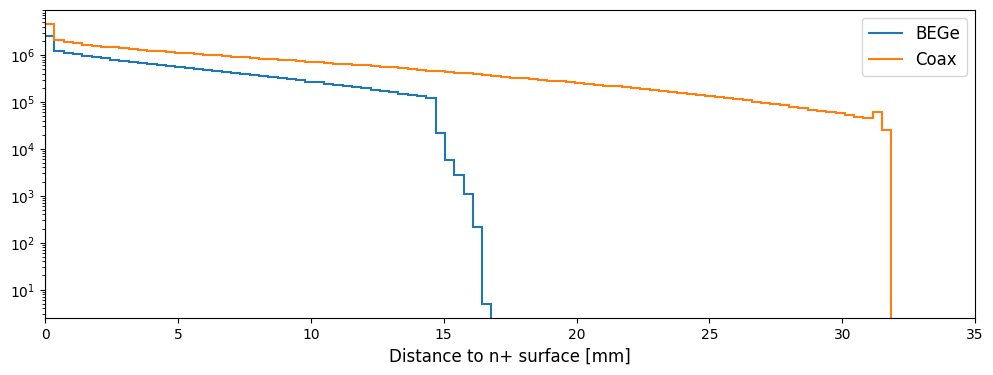

In [28]:
fig,ax = plt.subplots()
plot_distances(ax,ak.flatten(data_det001.distance_to_nplus_surface_mm),xrange=(0,35),label="BEGe",histtype="step",yerr=False)
plot_distances(ax,ak.flatten(data_det002.distance_to_nplus_surface_mm),xrange=(0,35),label="Coax",histtype="step",yerr=False)


### 4.3) Summed energies
Our processing chain also sums the energies of the hits, both before and after weighting by the activeness.


In [29]:
def plot_energy(axes,energy,bins=400,xrange=None,label=" ",log_y=True,**kwargs):
    
    h=hist.new.Reg(bins,*xrange, name="energy [keV]").Double()
    h.fill(energy)
    h.plot(**kwargs,label=label)
    axes.legend()
    if (log_y):
        axes.set_yscale("log")
    if xrange is not None:
        axes.set_xlim(*xrange)

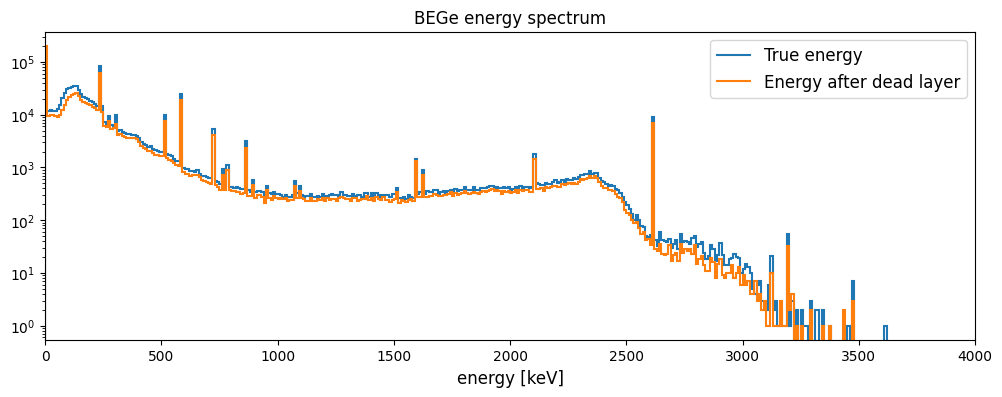

In [30]:
fig, ax = plt.subplots()
ax.set_title("BEGe energy spectrum")
plot_energy(ax,data_det001.energy_sum,yerr=False,label="True energy",xrange=(0,4000))
plot_energy(ax,data_det001.energy_sum_deadlayer,yerr=False,label="Energy after dead layer",xrange=(0,4000))

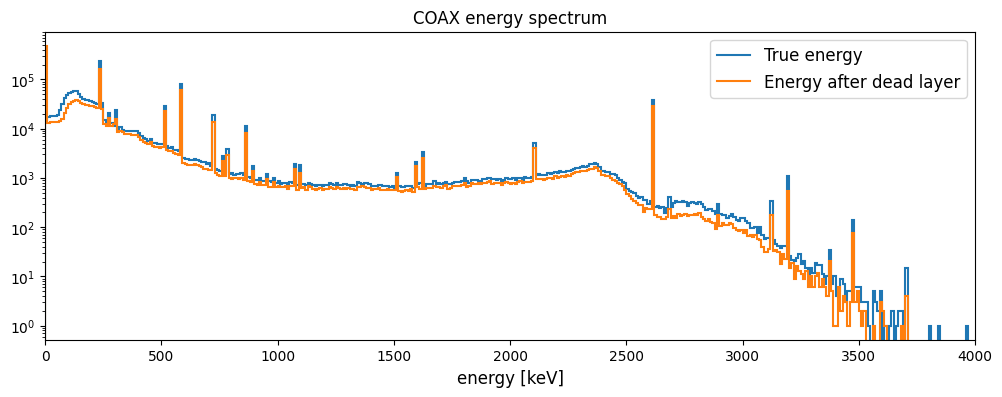

In [31]:
fig, ax = plt.subplots()
ax.set_title("COAX energy spectrum")
plot_energy(ax,data_det002.energy_sum,yerr=False,label="True energy",xrange=(0,4000))
plot_energy(ax,data_det002.energy_sum_deadlayer,yerr=False,label="Energy after dead layer",xrange=(0,4000))

### 4.4) Smearing
The final step in the processing chain smeared the energies by the energy resolution. This represents a general class of processors based on ''heuristic'' models.
Other similar processors could be implemented in a similar way. It would also be simple to use insted an energy dependent resolution curve.
To see the effect we have to zoom into the 2615 keV peak.

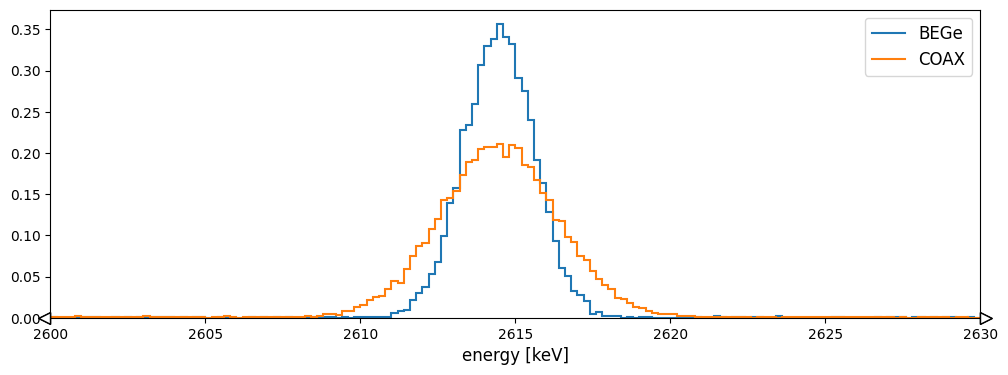

In [32]:
fig, axs = plt.subplots()
plot_energy(axs,data_det001.energy_sum_smeared,yerr=False,label="BEGe",xrange=(2600,2630),log_y=False,bins=150,density=True)
plot_energy(axs,data_det002.energy_sum_smeared,yerr=False,label="COAX",xrange=(2600,2630),log_y=False,bins=150,density=True)

We see clearly the worse energy resolution for the COAX detector.
> **To Do**: add a gaussian fit of this.

### Part 5) Adding a new processor

The next part of the tutorial describes how to add a new processor to the chain. We use as an example spatial *clustering* of steps.
This will be added later. 